In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pyomo.environ import *
from pyomo.gdp import *

## Model formulation

Each task is indexed by an ordered pair $(j,m)$ where $j$ is a job, and $m$ is a machine. Associated with each task is data describing the time needed to perform the task, and a preceeding task that must be completed before the index task can start.

| Parameter | Description |
| :-------- | :-----------|
| $\text{dur}_{j,m}$ | Duration of task $(j,m)$ | 
| $\text{prec}_{j,m}$ | A task $(k,n) = \text{prec}_{j,m}$ that must be completed before task $(j,m)$| 

The choice of decision variables for this problem are key to modeling. We introduce $makespan$ as the time needed to complete all tasks. $makespan$ is a candidate objective function. Variable $start_{j,m}$ denotes the time when task $(j,m)$ begins.  

| Decision Variables | Description |
| :-------- | :-----------|
| $\text{makespan}$  | Completion of all jobs | 
| $\text{start}_{j,m}$ | Start time for task $(j,m)$ |

The constraints include lower bounda on the start and an upper bound on the completion of each task $(j,m)$

\begin{align}
\text{start}_{j,m} & \geq 0\\
\text{start}_{j,m}+\text{dur}_{j,m} & \leq \text{makespan}
\end{align}

Any preceeding tasks must be completed before task $(j,m)$ can start.

\begin{align}
\text{start}_{k,n}+\text{dur}_{k,n}\leq\text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{prec}_{j,m}
\end{align}

Finally, for every task performed on machine $m$, there can be no overlap among those tasks. This leads to a set of pair-wise disjunctive constraints for each machine.

\begin{align}
\left[\text{start}_{j,m}+\text{dur}_{j,m} \leq \text{start}_{k,m}\right] \vee \left[\text{start}_{k,m}+\text{dur}_{k,m} \leq \text{start}_{j,m}\right]
\end{align}

avoids conflicts for use of the same machine. 

In [11]:
TASKS = {
    ('job_1','machine_1')   : {'dur': 10, 'prec': None},
    ('job_1','machine_2') : {'dur': 8, 'prec': ('job_1','machine_1')},
    ('job_1','machine_3')   : {'dur': 4, 'prec': ('job_1','machine_2')},
    ('job_2','machine_2')  : {'dur': 8, 'prec': None},
    ('job_2','machine_1') : {'dur': 3, 'prec': ('job_2','machine_2')},
    ('job_2','machine_4')   : {'dur': 5, 'prec': ('job_2','machine_1')},
    ('job_2','machine_3')  : {'dur': 6, 'prec': ('job_2','machine_4')},
    ('job_3','machine_1') : {'dur': 4, 'prec': None},
    ('job_3','machine_2') : {'dur': 7, 'prec': ('job_3','machine_1')},
    ('job_3','machine_4') : {'dur': 3, 'prec': ('job_3','machine_2')},

}

In [12]:
def jobshop_model(TASKS):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
                          filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
                             filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
    model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
    model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
    [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
     model.start[k,m] + model.dur[k,m] <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [13]:
def jobshop_solve(model):
    SolverFactory('gurobi').solve(model)
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'job_1',
  'Machine': 'machine_1',
  'Start': 0.0,
  'Duration': 10,
  'Finish': 10.0},
 {'Job': 'job_1',
  'Machine': 'machine_2',
  'Start': 10.0,
  'Duration': 8,
  'Finish': 18.0},
 {'Job': 'job_1',
  'Machine': 'machine_3',
  'Start': 18.0,
  'Duration': 4,
  'Finish': 22.0},
 {'Job': 'job_2',
  'Machine': 'machine_2',
  'Start': 0.0,
  'Duration': 8,
  'Finish': 8.0},
 {'Job': 'job_2',
  'Machine': 'machine_1',
  'Start': 13.999999999999982,
  'Duration': 3,
  'Finish': 16.999999999999982},
 {'Job': 'job_2',
  'Machine': 'machine_4',
  'Start': 16.999999999999982,
  'Duration': 5,
  'Finish': 21.999999999999982},
 {'Job': 'job_2',
  'Machine': 'machine_3',
  'Start': 22.0,
  'Duration': 6,
  'Finish': 28.0},
 {'Job': 'job_3',
  'Machine': 'machine_1',
  'Start': 10.0,
  'Duration': 4,
  'Finish': 14.0},
 {'Job': 'job_3',
  'Machine': 'machine_2',
  'Start': 17.999999999999957,
  'Duration': 7,
  'Finish': 24.999999999999957},
 {'Job': 'job_3',
  'Machine': 'machine_4',
 

In [14]:
schedule = pd.DataFrame(results)
schedule

,Job,Machine,Start,Duration,Finish
0,job_1,machine_1,0.0,10,10.0
1,job_1,machine_2,10.0,8,18.0
2,job_1,machine_3,18.0,4,22.0
3,job_2,machine_2,0.0,8,8.0
4,job_2,machine_1,14.0,3,17.0
5,job_2,machine_4,17.0,5,22.0
6,job_2,machine_3,22.0,6,28.0
7,job_3,machine_1,10.0,4,14.0
8,job_3,machine_2,18.0,7,25.0
9,job_3,machine_4,25.0,3,28.0


In [15]:
schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine'])

Start  Duration  Finish
Job   Machine                           
job_1 machine_1    0.0        10    10.0
      machine_2   10.0         8    18.0
      machine_3   18.0         4    22.0
job_2 machine_2    0.0         8     8.0
      machine_1   14.0         3    17.0
      machine_4   17.0         5    22.0
      machine_3   22.0         6    28.0
job_3 machine_1   10.0         4    14.0
      machine_2   18.0         7    25.0
      machine_4   25.0         3    28.0

In [16]:
schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job'])

Start  Duration  Finish
Machine   Job                           
machine_1 job_1    0.0        10    10.0
          job_3   10.0         4    14.0
          job_2   14.0         3    17.0
machine_2 job_2    0.0         8     8.0
          job_1   10.0         8    18.0
          job_3   18.0         7    25.0
machine_3 job_1   18.0         4    22.0
          job_2   22.0         6    28.0
machine_4 job_2   17.0         5    22.0
          job_3   25.0         3    28.0

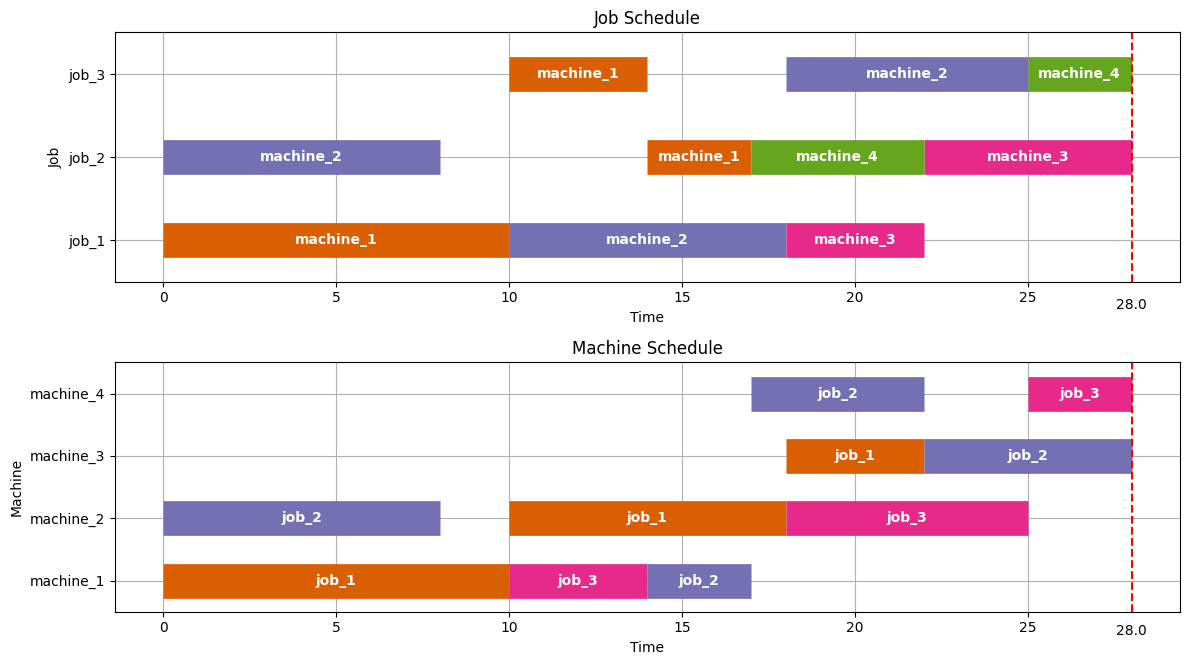

In [17]:
def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

visualize(results)